In [1]:
from qiskit import QuantumCircuit, QiskitError
#from qiskit import execute, BasicAer
import qiskit.ignis.verification.randomized_benchmarking as rb
#import qiskit.test.benchmarks.randomized_benchmarking as br
import pyzx
from pyzx.circuit.qasmparser import QASMParser
from pyzx.circuit.qiskitqasmparser import QiskitQASMParser

In [2]:
#qc = rb.randomized_benchmarking_seq()
qc = rb.randomized_benchmarking_seq(nseeds=1, length_vector=None,
                                rb_pattern=[[0,1]],
                                length_multiplier=1, seed_offset=0,
                                align_cliffs=False,
                                interleaved_gates=None,
                                is_purity=False)
qc = qc[0][0][0]
type(qc)

qiskit.circuit.quantumcircuit.QuantumCircuit

In [ ]:
# setting up the backend
# print(BasicAer.backends())

# running the job
# job_sim = execute(qc, BasicAer.get_backend('qasm_simulator'))
# sim_result = job_sim.result()

In [ ]:
# print("\nPrint all gates:")
# [print(dat) for dat in qc.data]

In [3]:
qasm = qc.qasm()
#qasm = '\n'.join(['' if line.startswith("barrier") else line for line in qasm.splitlines()])

print("\nPrint QASM:")
print(qasm)




Print QASM:
OPENQASM 2.0;
include "qelib1.inc";
qreg qr[2];
creg cr[2];
h qr[1];
h qr[0];
s qr[0];
cx qr[0],qr[1];
h qr[0];
s qr[0];
z qr[0];
barrier qr[0],qr[1];
z qr[0];
sdg qr[0];
h qr[0];
cx qr[0],qr[1];
sdg qr[0];
h qr[0];
h qr[1];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];



In [4]:
# Draw the circuit
print(qc)

         ┌───┐┌───┐     ┌───┐┌───┐┌───┐ ░ ┌───┐┌─────┐┌───┐     ┌─────┐┌───┐┌─┐
qr_0: |0>┤ H ├┤ S ├──■──┤ H ├┤ S ├┤ Z ├─░─┤ Z ├┤ Sdg ├┤ H ├──■──┤ Sdg ├┤ H ├┤M├
         ├───┤└───┘┌─┴─┐└───┘└───┘└───┘ ░ └───┘└─────┘└───┘┌─┴─┐└┬───┬┘└┬─┬┘└╥┘
qr_1: |0>┤ H ├─────┤ X ├────────────────░──────────────────┤ X ├─┤ H ├──┤M├──╫─
         └───┘     └───┘                ░                  └───┘ └───┘  └╥┘  ║ 
 cr_0: 0 ════════════════════════════════════════════════════════════════╬═══╩═
                                                                         ║     
 cr_1: 0 ════════════════════════════════════════════════════════════════╩═════
                                                                               


In [5]:
p = QiskitQASMParser()
circ_list, whichpyzx = p.qiskitparse(qasm)
print(circ_list)
print(whichpyzx)
print(p.registers)

['qreg qr[2];', 'creg cr[2];', Circuit(2 qubits, 7 gates), 'barrier qr[0],qr[1];', Circuit(2 qubits, 7 gates), 'measure qr[0] -> cr[0];', 'measure qr[1] -> cr[1];']
[2, 4]
{'qr': (0, 2)}


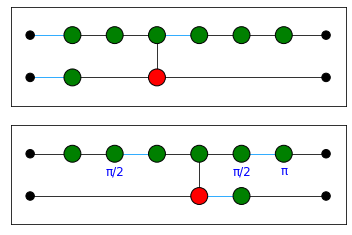

In [6]:
#qasm = qc.decompose().qasm()
pyzx.draw_many(circ_list, whichpyzx)


#print(circ_list)
#print(len(circ_list))
#print(whichpyzx)
# whichplt = 0
# for i in range(len(circ_list)):
#     if isinstance(circ_list[i], str):
#         pass
#     else:
#         circ_list[i].name = "pyzx_" + qc.name + "_" + str(i)
#         plt.axes(axs[whichplt])
#         fig = pyzx.draw(circ_list[i])
#         break
#plt.show()
#c.name = "pyzx_" + qc.name
#pyzx.draw(c)
#pyzx.draw(c.to_graph(), layout=None, labels=False, figsize=(16,4), h_edge_draw='blue', rows=None)

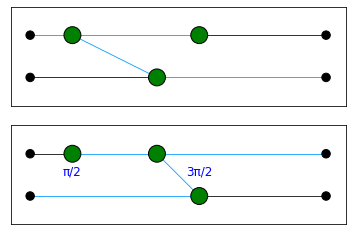

In [15]:
graph_list = [circ_list[w].to_graph() for w in whichpyzx]
[pyzx.full_reduce(g) for g in graph_list]
pyzx.draw_many(graph_list, range(len(whichpyzx)))

In [16]:
# pyzx.draw(graph_list[1])
# new_c = pyzx.extract.streaming_extract(graph_list[1])
# print(new_c.to_basic_gates().to_qasm())

pyzx_circ_list = [pyzx.extract.streaming_extract(g) for g in graph_list]
pyzx_circ_list = [pyzx.optimize.basic_optimization(new_c.to_basic_gates()) for new_c in pyzx_circ_list]

##new_c = c.from_graph(g)
pyzx_qasm = [new_c.to_basic_gates().to_qasm() for new_c in pyzx_circ_list]

#pyzx_qasm = ["\n".join(circ.splitlines()[2:]) for circ in pyzx_qasm]
pyzx_qasm = ["\n".join(['' if line.startswith("qreg") else line for line in circ.splitlines()[2:]]) for circ in pyzx_qasm]



In [17]:
##pyzx_qasm = [string.replace(';', '') for string in pyzx_qasm]
for new_qasm in pyzx_qasm:
    [print(line) for line in new_qasm.splitlines()]
    print()


cx q[1], q[0];
h q[1];
rz(1.5*pi) q[0];
h q[0];
z q[0];


h q[0];
rz(1.5*pi) q[0];
h q[1];
cx q[1], q[0];
x q[0];



In [46]:
#now we need to map registers and glue all the pieces back together
for i in range(len(pyzx_qasm)):
    circ_list[whichpyzx[i]] = pyzx_qasm[i]
#print(circ_list)
## join the
qasm_string = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'+"\n".join(circ_list)
qasm_string = qasm_string.replace('q[', 'qr[')
print(qasm_string)

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[2];
creg cr[2];

cx q[1], q[0];
h q[1];
rz(1.5*pi) q[0];
h q[0];
z q[0];
barrier qr[0],qr[1];

h q[0];
rz(1.5*pi) q[0];
h q[1];
cx q[1], q[0];
x q[0];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];


In [ ]:
# pqsl = [line + "\n" for line in pyzx_qasm] #took out .splitlines()
# qsl = [line + "\n" for line in qasm.splitlines()]
# # print(pqsl)
# # print(qsl)
# new_qasm = '\n'.join(qsl[0:4]) + ''.join(pqsl[3:]) + ''.join(qsl[-2:])
# new_qasm = new_qasm.replace('q[', 'qr[')
# print(new_qasm)

In [19]:
new_qc = qc.from_qasm_str(qasm_string)
print(new_qc)

         ┌───┐┌────────────┐┌───┐┌───┐ ░ ┌───┐┌────────────┐┌───┐┌───┐┌─┐
qr_0: |0>┤ X ├┤ Rz(1.5*pi) ├┤ H ├┤ Z ├─░─┤ H ├┤ Rz(1.5*pi) ├┤ X ├┤ X ├┤M├
         └─┬─┘└───┬───┬────┘└───┘└───┘ ░ ├───┤└────────────┘└─┬─┘└┬─┬┘└╥┘
qr_1: |0>──■──────┤ H ├────────────────░─┤ H ├────────────────■───┤M├──╫─
                  └───┘                ░ └───┘                    └╥┘  ║ 
 cr_0: 0 ══════════════════════════════════════════════════════════╬═══╩═
                                                                   ║     
 cr_1: 0 ══════════════════════════════════════════════════════════╩═════
                                                                         


In [20]:
print(qc)

         ┌───┐┌───┐     ┌───┐┌───┐┌───┐ ░ ┌───┐┌─────┐┌───┐     ┌─────┐┌───┐┌─┐
qr_0: |0>┤ H ├┤ S ├──■──┤ H ├┤ S ├┤ Z ├─░─┤ Z ├┤ Sdg ├┤ H ├──■──┤ Sdg ├┤ H ├┤M├
         ├───┤└───┘┌─┴─┐└───┘└───┘└───┘ ░ └───┘└─────┘└───┘┌─┴─┐└┬───┬┘└┬─┬┘└╥┘
qr_1: |0>┤ H ├─────┤ X ├────────────────░──────────────────┤ X ├─┤ H ├──┤M├──╫─
         └───┘     └───┘                ░                  └───┘ └───┘  └╥┘  ║ 
 cr_0: 0 ════════════════════════════════════════════════════════════════╬═══╩═
                                                                         ║     
 cr_1: 0 ════════════════════════════════════════════════════════════════╩═════
                                                                               


In [22]:
import qiskit
from qiskit.providers.basicaer import QasmSimulatorPy
c1 = qiskit.execute(qc, QasmSimulatorPy()).result().get_counts()
c2 = qiskit.execute(new_qc, QasmSimulatorPy()).result().get_counts()

In [23]:
c1

{'00': 1024}

In [24]:
c2

{'00': 1024}

In [25]:
qc.depth()

13

In [26]:
qc.size()

16

In [27]:
new_qc.depth()

9

In [28]:
new_qc.size()

12

In [44]:
new_new_qc = qiskit.transpile(qc, basis_gates=['u3', 'cx'], optimization_level=2)

In [45]:
print(new_new_qc)

         ┌──────────────────┐     ┌───────────────────┐ ░ ┌─────────────┐     »
qr_0: |0>┤ U3(pi/2,pi/2,pi) ├──■──┤ U3(pi/2,-pi/2,pi) ├─░─┤ U2(0,3pi/2) ├──■──»
         └───┬──────────┬───┘┌─┴─┐└───────────────────┘ ░ └─────────────┘┌─┴─┐»
qr_1: |0>────┤ U2(0,pi) ├────┤ X ├──────────────────────░────────────────┤ X ├»
             └──────────┘    └───┘                      ░                └───┘»
 cr_0: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
 cr_1: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
«      ┌────────────┐┌─┐   
«qr_0: ┤ U2(0,pi/2) ├┤M├───
«      └┬──────────┬┘└╥┘┌─┐
«qr_1: ─┤ U2(0,pi) ├──╫─┤M├
«       └──────────┘  ║ └╥┘
«cr_0: ═══════════════╩══╬═
«                        ║ 
«cr_1: ══════════════════╩═
«                          


In [40]:
new_new_qc.depth()

7

In [34]:
new_new_qc.size()

10

In [35]:
doubly_qc = qiskit.transpile(new_qc, basis_gates=['u3', 'cx'], optimization_level=2)
print(doubly_qc)

         ┌───┐┌───────────────────┐ ░ ┌───────────────────┐┌───┐┌─────────────┐»
qr_0: |0>┤ X ├┤ U3(pi/2,pi,5pi/2) ├─░─┤ U3(pi/2,-pi/2,pi) ├┤ X ├┤ U3(pi,0,pi) ├»
         └─┬─┘└────┬──────────┬───┘ ░ └────┬──────────┬───┘└─┬─┘└─────┬─┬─────┘»
qr_1: |0>──■───────┤ U2(0,pi) ├─────░──────┤ U2(0,pi) ├──────■────────┤M├──────»
                   └──────────┘     ░      └──────────┘               └╥┘      »
 cr_0: 0 ══════════════════════════════════════════════════════════════╬═══════»
                                                                       ║       »
 cr_1: 0 ══════════════════════════════════════════════════════════════╩═══════»
                                                                               »
«      ┌─┐
«qr_0: ┤M├
«      └╥┘
«qr_1: ─╫─
«       ║ 
«cr_0: ═╩═
«         
«cr_1: ═══
«         


In [36]:
doubly_qc.depth()

6

In [37]:
doubly_qc.size()

9